In [1]:
import os
import torch
import torch.nn as nn
import pydicom as dicom # to read DCM images
from PIL import Image  # to read PNGs
import matplotlib.pylab as plt
import numpy as np
from collections import deque  # Import deque for efficient queue operations

class imageProcessor():
    def __init__(self, image, x_pix, y_pix):
        # Constructor to initialize the image processor object.
        # Reads the image, sets up the seed pixel and threshold values.
        
        self.ds = image
        self.row, self.col = self.ds.shape  # Get the dimensions of the image (rows, columns)
        
        # Normalize the image pixel values to range [0, 1] by dividing by the maximum value
        self.img_intent = self.ds / self.ds.max()  
        
        # Initialize an empty mask with the same shape as the image
        self.mask = np.zeros((self.row, self.col))
        
        # Initialize an array to store gradient information from the Sobel Filter
        self.gradient = np.zeros((self.row, self.col))
        
        # Set the seed pixel (starting point) coordinates
        self.seed_row = y_pix
        self.seed_col = x_pix

    def showMask(self):
        # Display the mask image using matplotlib
        plt.imshow(self.mask, 'gray')

    def showImage(self):
        # Display the image pixel intensity array using matplotlib
        plt.imshow(self.img_intent, 'gray')

    def sobelFilter(self):
        # Define Sobel kernels
        x_kernel = np.array([[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]])

        y_kernel = np.array([[-1, -2, -1],
                             [ 0,  0,  0],
                             [ 1,  2,  1]])

        # Compute gradient magnitude using Sobel operator
        for y in range(1, self.row - 1):
            for x in range(1, self.col - 1):
                region = self.img_intent[y-1:y+2, x-1:x+2]
                gx = np.sum(region * x_kernel)
                gy = np.sum(region * y_kernel)
                self.gradient[y, x] = np.sqrt(gx**2 + gy**2)

    def equalizeImageHistogram(self):
        flat = self.img_intent.flatten()
        hist, bins = np.histogram(flat, bins=256, range=[0, 1], density=True)
        cdf = hist.cumsum()
        cdf_normalized = cdf / cdf[-1]
        img_eq = np.interp(flat, bins[:-1], cdf_normalized)
        self.img_intent = img_eq.reshape(self.img_intent.shape)
    
    def equalizeGradientHistogram(self):
        flat = self.gradient.flatten()
        hist, bins = np.histogram(flat, bins=256, range=[0, 1], density=True)
        cdf = hist.cumsum()
        cdf_normalized = cdf / cdf[-1]
        img_eq = np.interp(flat, bins[:-1], cdf_normalized)
        self.gradient = img_eq.reshape(self.gradient.shape)

    def preprocess(self):
        # Compute gradients
        self.equalizeImageHistogram()
        self.sobelFilter()
        self.gradient = self.gradient / self.gradient.max()
        self.equalizeGradientHistogram()
        
    def edgeDetection(self, thresh_coeff):
        # Initialize the BFS queue with the seed pixel
        queue = deque([(self.seed_row, self.seed_col)])
        thresh = self.gradient[self.seed_row-2:self.seed_row+3, self.seed_col-2:self.seed_col+3].mean() + thresh_coeff*self.gradient[self.seed_row-4:self.seed_row+5, self.seed_col-4:self.seed_col+5].std() 

        # Mark the seed pixel in the mask as visited (part of the region)
        self.mask[self.seed_row, self.seed_col] = 1

        # Perform BFS to grow the region
        while queue:
            current_row, current_col = queue.popleft()

            # Explore 4-connected neighbors (up, down, left, right)
            for delta_row, delta_col in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                neighbor_row = current_row + delta_row
                neighbor_col = current_col + delta_col

                # Ensure the neighbor is within image bounds and not visited
                if 0 <= neighbor_row < self.row and 0 <= neighbor_col < self.col and self.mask[neighbor_row, neighbor_col] == 0:
                        # Add the neighbor to the queue and mark it as part of the region (visited)
                    if(self.gradient[neighbor_row, neighbor_col] <= thresh):
                        queue.append((neighbor_row, neighbor_col))
                        self.mask[neighbor_row, neighbor_col] = 1  # Mark as part of the region
    
    def intensityThreshold(self):
        # Calculate the average intensity of the masked region
        average_intensity = np.mean(self.img_intent[self.mask == 1])
        intensity_thresh = 1.5*np.std(self.img_intent[self.mask == 1])
        # Initialize a queue for processing pixels and a set to track visited pixels to avoid revisiting
        intensity_queue = deque([(self.seed_row, self.seed_col)])  # Add the seed pixel to the queue
        intensity_visited = set([(self.seed_row, self.seed_col)])  # Mark the seed pixel as visited

        # Directions for exploring neighboring pixels (right, down, left, up)
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up

        # Start the region-growing process for intensity-based filling
        while intensity_queue:
            x, y = intensity_queue.popleft()  # Get the current pixel from the front of the queue

            # Explore all neighboring pixels (right, down, left, up)
            for dx, dy in directions:
                nx, ny = x + dx, y + dy  # Calculate the coordinates of the neighboring pixel

                # Check if the neighboring pixel is within the bounds of the image and not already visited
                if 0 <= nx < self.row and 0 <= ny < self.col and (nx, ny) not in intensity_visited:
                    # Check if the neighboring pixel is within the intensity threshold bounds
                    if (average_intensity-intensity_thresh < self.img_intent[nx, ny] < average_intensity+intensity_thresh):
                        # Mark the neighboring pixel as visited and add it to the queue for further processing
                        intensity_visited.add((nx, ny))
                        intensity_queue.append((nx, ny))
                        self.mask[nx, ny] = 1  # Mark the pixel as part of the re
    
    def process(self):
        self.preprocess()
        thresh_coeff = 0.001
        while(self.mask.sum() < 50):
            self.edgeDetection(thresh_coeff)
            thresh_coeff += 0.001
        self.intensityThreshold()

def process(input_img,x,y):
    img = imageProcessor(input_img,x,y)
    img.process()
    return img.mask

In [2]:
def load_data(path):
    dicom_folder = os.path.join(path, "DICOM_anon")
    png_folder = os.path.join(path, "Ground")

    dcm_files = sorted([f for f in os.listdir(dicom_folder) if f.endswith('.dcm')])
    png_files = sorted([f for f in os.listdir(png_folder) if f.endswith('.png')])

    dcm_images = []
    png_images = []

    for dcm_file, png_file in zip(dcm_files, png_files):
        # Read and normalize DICOM image
        dcm_path = os.path.join(dicom_folder, dcm_file)
        ds = dicom.dcmread(dcm_path)
        img = ds.pixel_array.astype(np.float32)
        img = img / img.max() if img.max() > 0 else img
        dcm_images.append(img)

        # Read and binarize PNG label
        png_path = os.path.join(png_folder, png_file)
        label = Image.open(png_path).convert("L")
        label = np.array(label) > 0  # boolean mask
        png_images.append(label)

    # Stack into tensors
    training_tensor = np.stack(dcm_images, axis=0)
    label_tensor = np.stack(png_images, axis=0)

    return training_tensor, label_tensor

In [3]:
### Patient number 8: test data

In [4]:
[p8_data,p8_truth] = load_data("Testing_Data/Patient_8")
p8_data.shape

(5, 512, 512)

In [5]:
p8_i1 = process(p8_data[0],250,150)
p8_i2 = process(p8_data[1],150,150)
p8_i3 = process(p8_data[2],120,200)
p8_i4 = process(p8_data[3],120,200)
p8_i5 = process(p8_data[4],100,220)

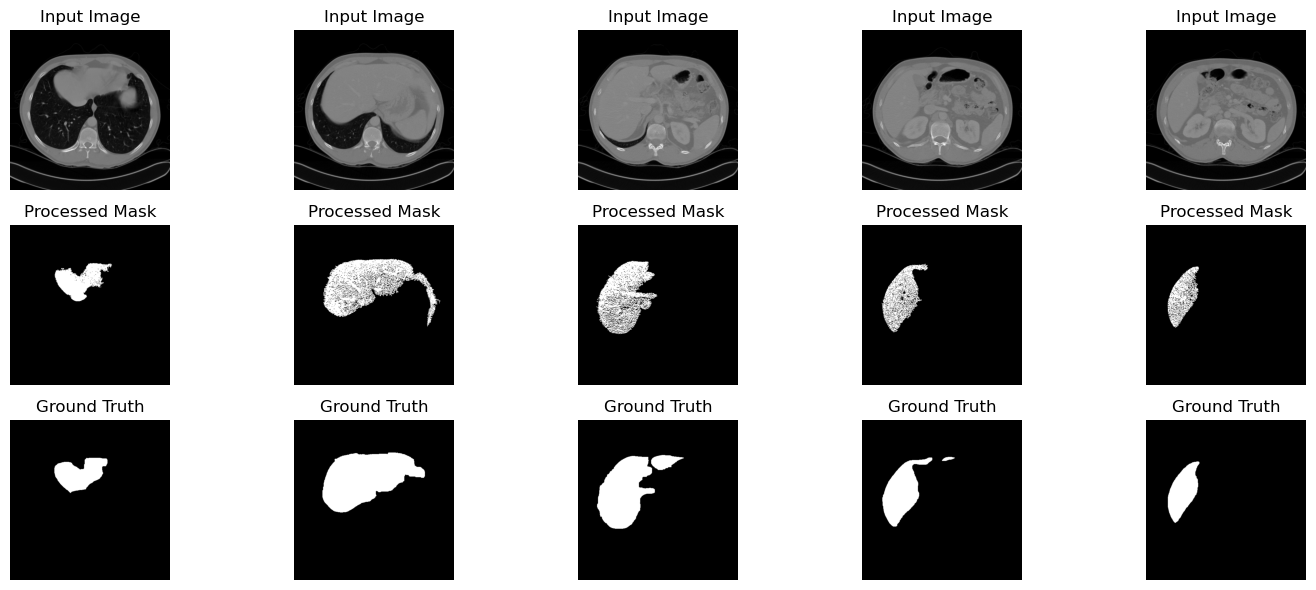

In [6]:
# input images
input_image8 = [p8_data[i] for i in range(5)]

# Assume these are your named variables (images)
processed8 = [p8_i1, p8_i2, p8_i3, p8_i4, p8_i5]

# Get 5 slices for the second row
bottom_row8 = [p8_truth[i] for i in range(5)]

# Create 2 rows and 5 columns of subplots
fig, axes = plt.subplots(3, 5, figsize=(15, 6))

# Top row: Input Images
for i, ax in enumerate(axes[0]):
    ax.imshow(input_image8[i], cmap='gray' if input_image8[i].ndim == 2 else None)
    ax.axis('off')
    ax.set_title(f'Input Image')  # Optional: customize titles

# Top row: named variables
for i, ax in enumerate(axes[1]):
    ax.imshow(processed8[i], cmap='gray' if processed8[i].ndim == 2 else None)
    ax.axis('off')
    ax.set_title(f'Processed Mask')  # Optional: customize titles

# Bottom row: tensor slices
for i, ax in enumerate(axes[2]):
    ax.imshow(bottom_row8[i], cmap='gray' if bottom_row8[i].ndim == 2 else None)
    ax.axis('off')
    ax.set_title(f'Ground Truth')  # Optional: customize titles

plt.tight_layout()
plt.show()

In [7]:
### Patient number 18: test data

In [8]:
[p18_data,p18_truth] = load_data("Testing_Data/Patient_18")
p8_data.shape

(5, 512, 512)

In [9]:
p18_i1 = process(p18_data[0],240,220)
p18_i2 = process(p18_data[1],180,200)
p18_i3 = process(p18_data[2],150,250)
p18_i4 = process(p18_data[3],140,250)
p18_i5 = process(p18_data[4],100,220)

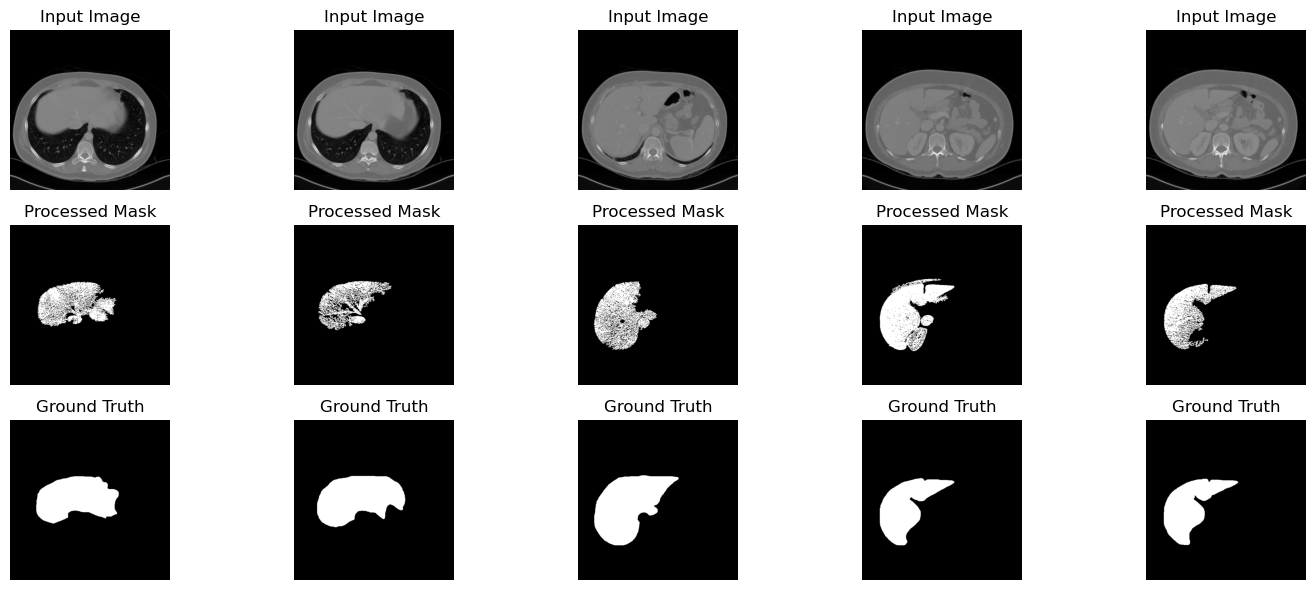

In [10]:
# input images
input_image18 = [p18_data[i] for i in range(5)]

# Assume these are your named variables (images)
processed18 = [p18_i1, p18_i2, p18_i3, p18_i4, p18_i5]

# Get 5 slices for the second row
bottom_row18 = [p18_truth[i] for i in range(5)]

# Create 2 rows and 5 columns of subplots
fig, axes = plt.subplots(3, 5, figsize=(15, 6))

# Top row: Input Images
for i, ax in enumerate(axes[0]):
    ax.imshow(input_image18[i], cmap='gray' if input_image18[i].ndim == 2 else None)
    ax.axis('off')
    ax.set_title(f'Input Image')  # Optional: customize titles

# Top row: named variables
for i, ax in enumerate(axes[1]):
    ax.imshow(processed18[i], cmap='gray' if processed18[i].ndim == 2 else None)
    ax.axis('off')
    ax.set_title(f'Processed Mask')  # Optional: customize titles

# Bottom row: tensor slices
for i, ax in enumerate(axes[2]):
    ax.imshow(bottom_row18[i], cmap='gray' if bottom_row18[i].ndim == 2 else None)
    ax.axis('off')
    ax.set_title(f'Ground Truth')  # Optional: customize titles

plt.tight_layout()
plt.show()

In [11]:
### Patient number 18: test data

In [12]:
[p26_data,p26_truth] = load_data("Testing_Data/Patient_26")
p26_data.shape

(5, 512, 512)

In [13]:
p26_i1 = process(p26_data[0],170,220)
p26_i2 = process(p26_data[1],150,220)
p26_i3 = process(p26_data[2],120,200)
p26_i4 = process(p26_data[3],140,200)
p26_i5 = process(p26_data[4],120,250)

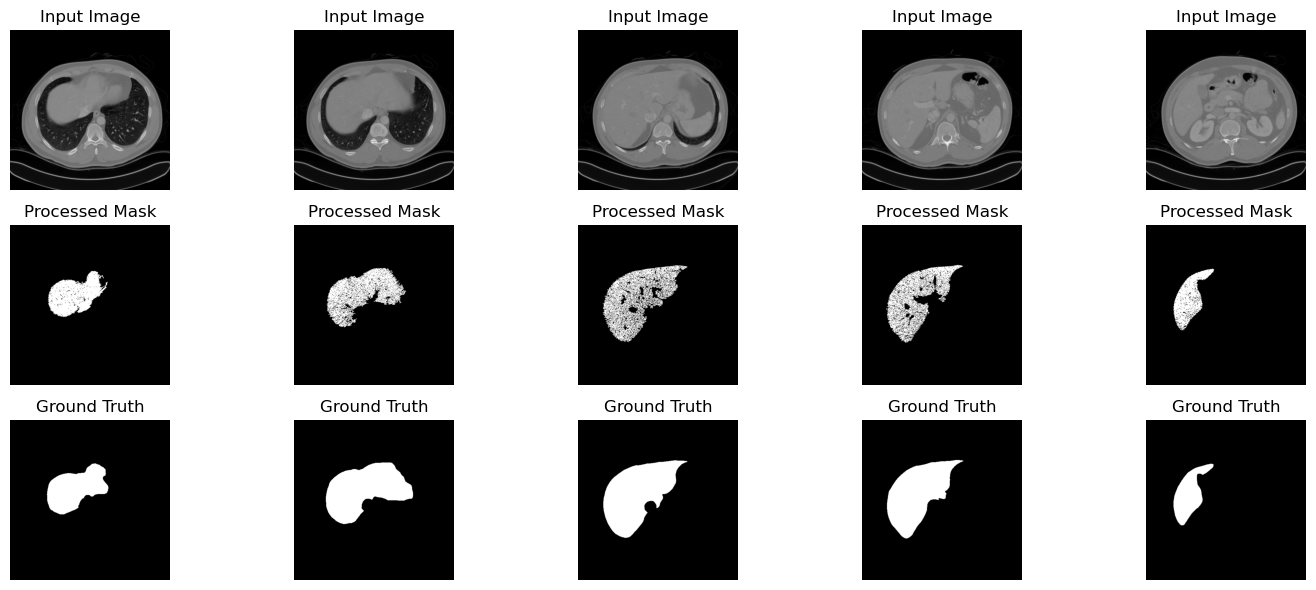

In [15]:
# input images
input_image26 = [p26_data[i] for i in range(5)]

# Assume these are your named variables (images)
processed26 = [p26_i1, p26_i2, p26_i3, p26_i4, p26_i5]

# Get 5 slices for the second row
bottom_row26 = [p26_truth[i] for i in range(5)]

# Create 2 rows and 5 columns of subplots
fig, axes = plt.subplots(3, 5, figsize=(15, 6))

# Top row: Input Images
for i, ax in enumerate(axes[0]):
    ax.imshow(input_image26[i], cmap='gray' if input_image26[i].ndim == 2 else None)
    ax.axis('off')
    ax.set_title(f'Input Image')  # Optional: customize titles

# Top row: named variables
for i, ax in enumerate(axes[1]):
    ax.imshow(processed26[i], cmap='gray' if processed26[i].ndim == 2 else None)
    ax.axis('off')
    ax.set_title(f'Processed Mask')  # Optional: customize titles

# Bottom row: tensor slices
for i, ax in enumerate(axes[2]):
    ax.imshow(bottom_row26[i], cmap='gray' if bottom_row26[i].ndim == 2 else None)
    ax.axis('off')
    ax.set_title(f'Ground Truth')  # Optional: customize titles

plt.tight_layout()
plt.show()

In [16]:
processed_list = [p8_i1, p8_i2, p8_i3, p8_i4, p8_i5, p18_i1, p18_i2, p18_i3, p18_i4, p18_i5, p26_i1, p26_i2, p26_i3, p26_i4, p26_i5]
truth_list = [p8_truth[i] for i in range(5)] + [p18_truth[i] for i in range(5)] + [p26_truth[i] for i in range(5)]

processed_tensor = np.stack(processed_list, axis=0)
truth_tensor = np.stack(truth_list, axis=0)

overlapMatrix = np.multiply(processed_tensor,truth_tensor)

truePositive = overlapMatrix.sum()
falsePositive = processed_tensor.sum() - overlapMatrix.sum()
falseNegative = truth_tensor.sum() - overlapMatrix.sum()
trueNegative = np.logical_and(processed_tensor == 0, truth_tensor == 0).sum()

sensitivity = truePositive/(truePositive+falseNegative)
specificity = trueNegative/(trueNegative+falsePositive)
accuracy = (truePositive+trueNegative)/(15*512*512)
precision = truePositive/(truePositive+falsePositive)

In [18]:
truePositive

269969.0

In [19]:
falsePositive

14059.0

In [20]:
falseNegative

117800.0

In [21]:
trueNegative

3530332

In [22]:
sensitivity

0.6962108884413143

In [23]:
specificity

0.9960334511626963

In [24]:
accuracy

0.9664665222167969

In [25]:
precision

0.9505013590209416

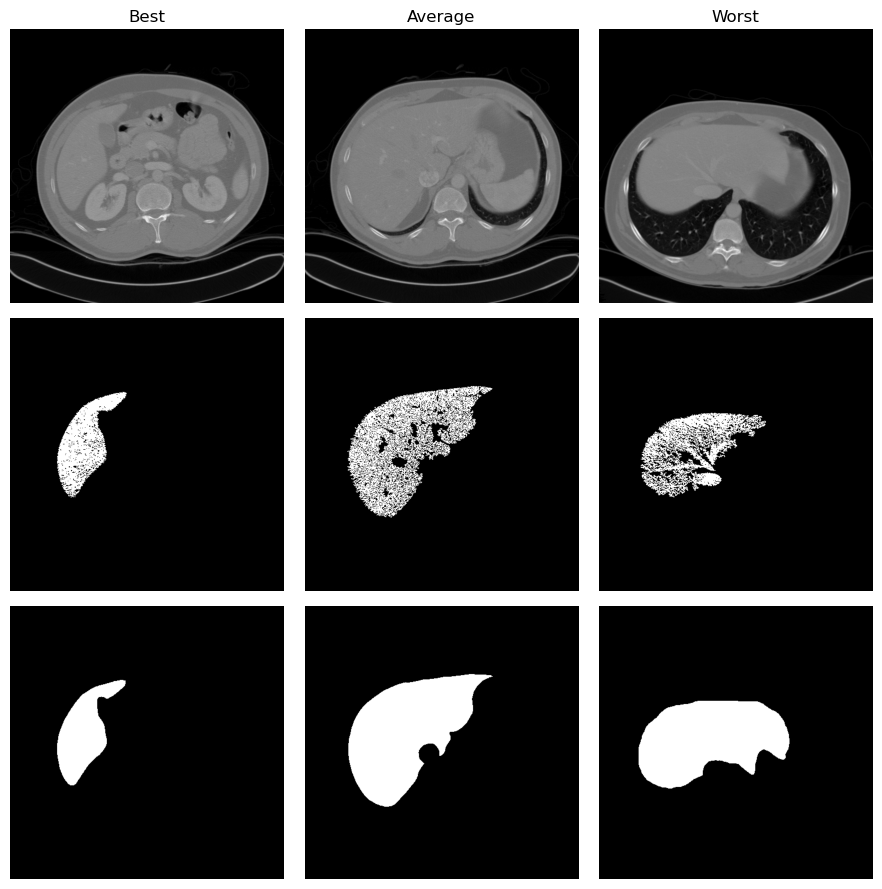

In [29]:
# Input images
best = [p26_data[4], p26_i5, p26_truth[4]]
average = [p26_data[2], p26_i3, p26_truth[2]]
worst = [p18_data[1], p18_i2, p18_truth[1]]

# Create 3 columns and 3 rows of subplots (3 rows, 1 per category; 3 columns, 1 per image type)
fig, axes = plt.subplots(3, 3, figsize=(9, 9))  # Adjust figsize for better aspect

# First column: Best Case
for i, ax in enumerate(axes[:, 0]):
    ax.imshow(best[i], cmap='gray' if best[i].ndim == 2 else None)
    ax.axis('off')
    ax.set_title('Best' if i == 0 else '')  # Optional: only top subplot gets a title

# Second column: Average
for i, ax in enumerate(axes[:, 1]):
    ax.imshow(average[i], cmap='gray' if average[i].ndim == 2 else None)
    ax.axis('off')
    ax.set_title('Average' if i == 0 else '')

# Third column: Worst Case
for i, ax in enumerate(axes[:, 2]):
    ax.imshow(worst[i], cmap='gray' if worst[i].ndim == 2 else None)
    ax.axis('off')
    ax.set_title('Worst' if i == 0 else '')

plt.tight_layout()
plt.savefig('comparison_plot.png', dpi=300) 
plt.show()

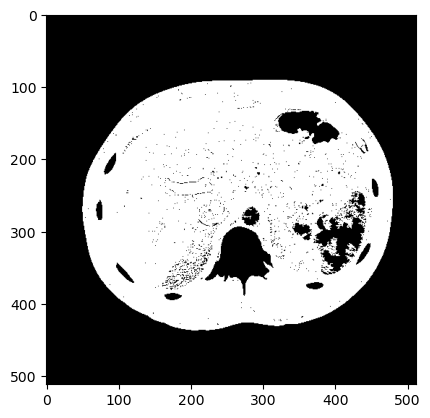

In [33]:
p26_i4 = process(p26_data[3],200,200)
plt.imshow(p26_i4, "gray")
plt.savefig('BadSeed.png', dpi=300) 